# Dynamic Quantum Convolutional Neural Networks
This notebook shows how to use the `dynamic_qcnn` package to generate Quantum Convolutional Neural Networks (QCNNs)

___
*A cute robot building itself with artifical intelligence, pencil drawing -  generated with* [Dall$\cdot$E 2](https://openai.com/dall-e-2/)

<img src="../img/DALL·E 2022-08-17 11.48.32 - A cute robot building itself with artifical intelligence, pencil drawing.png" alt="drawing" width="200"/>

In [4]:
# Load libraries
import sympy
import numpy as np
import cirq
from cirq.contrib.svg import SVGCircuit

In [5]:
from dynamic_qcnn import Qcnn_cirq as Qcnn_cirq
from dynamic_qcnn import (
    Qcnn,
    Qfree,
    Qconv,
    Qpool,
    Qdense,
    binary_tree_r,
    convert_graph_to_circuit_cirq,
    plot_graph,
    pretty_cirq_plot,
)

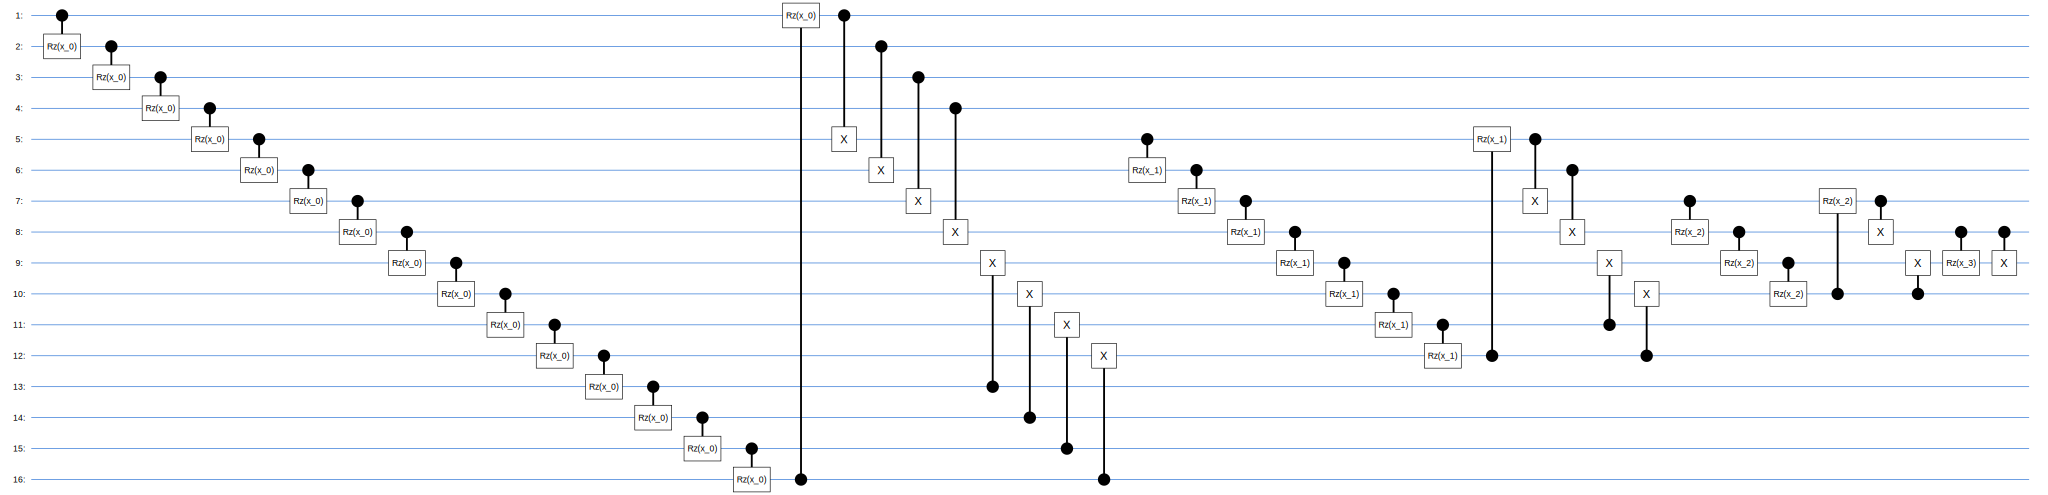

In [6]:
### Reverse binary tree
N = 8
# level 1
m1_1 = Qconv(1)
m1_2 = Qpool(filter="outside")
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

circuit, symbols = convert_graph_to_circuit_cirq(m3_1)
# m3_1 + Qfree([1,3,5]) + Qconv(5)+m3_1)*4
SVGCircuit(circuit)

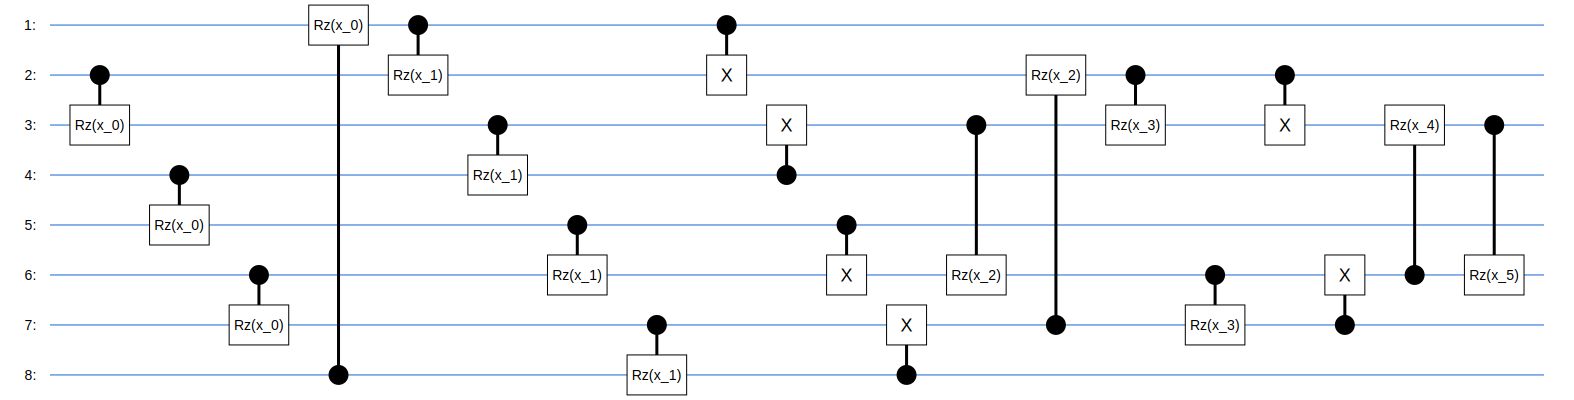

In [7]:
### MERA like
N = 8
# level 1
m1_1 = Qconv(1, 2)
m1_2 = Qconv(1, 2, 1)
m1_3 = Qpool(filter="1001")
m1_4 = Qpool(2, filter="001001")
m1_5 = Qpool(filter="outside")
# level 2
m2_1 = m1_2 + m1_1
m2_2 = m1_3 + m1_4
m2_3 = m1_5
# level 3
m3_1 = Qfree(N) + (m2_1 + m2_2) * 2 + m2_1

circuit, symbols = convert_graph_to_circuit_cirq(m3_1)
SVGCircuit(circuit)

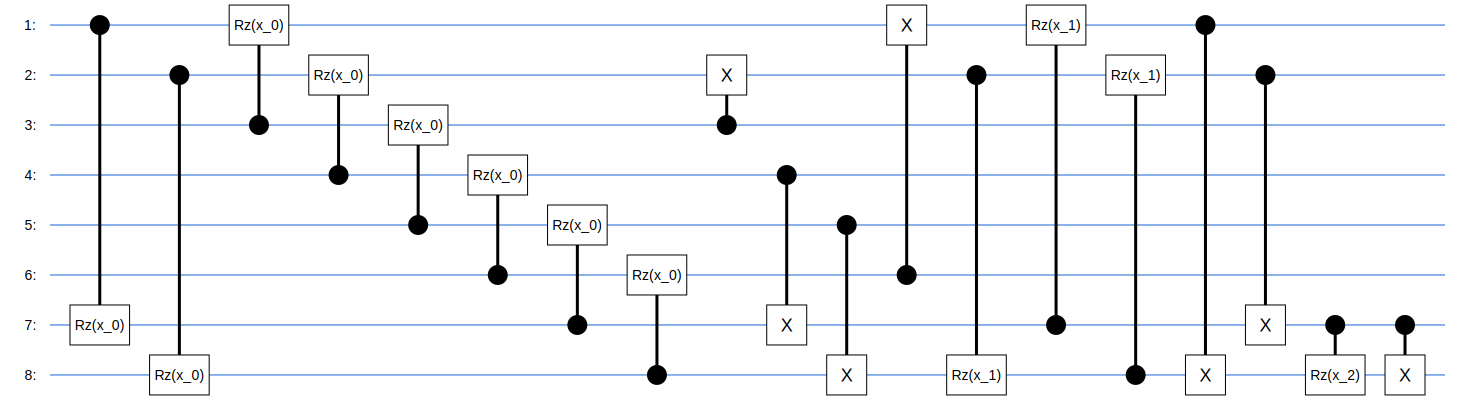

In [45]:
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [
        Qpool(s_p, filter=i_filter)
        for i_filter in ("right", "left", "even", "odd", "inside", "outside")
        for s_p in range(n)
    ]
    c = [
        Qconv(stride=s_c, step=s_t, offset=s_o)
        for s_c in range(1, n, 1)
        for s_t in range(1, 2, 1)
        for s_o in range(n)
    ] + [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

circuit, symbols = convert_graph_to_circuit_cirq(M)
SVGCircuit(circuit)

In [35]:
# Pooling circuit
def V(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rz(symbols[0]).on(q1)
    circuit += cirq.CNOT(q1, q0)
    circuit += cirq.rz(symbols[1]).on(q0)
    circuit += cirq.ry(symbols[2]).on(q1)
    circuit += cirq.CNOT(q0, q1)
    circuit += cirq.ry(symbols[3]).on(q1)
    return circuit


# Convolution circuit
def U(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rz(symbols[0]).on(q1)
    circuit += cirq.CNOT(q1, q0)
    circuit += cirq.rz(symbols[1]).on(q0)
    circuit += cirq.ry(symbols[2]).on(q1)
    circuit += cirq.CNOT(q0, q1)
    circuit += cirq.ry(symbols[3]).on(q1)
    circuit += cirq.CNOT(q1, q0)
    circuit += cirq.rz(symbols[4]).on(q0)
    return circuit

In [39]:
M = Qfree(8) + (Qconv(1, convolution_mapping=(U, 5)) + Qpool(filter="left", pooling_mapping=(V, 4)))* 3

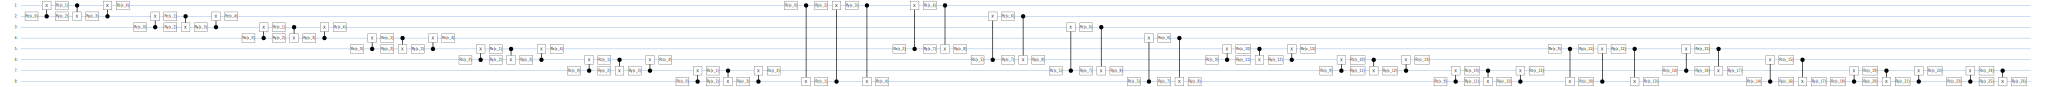

In [40]:
circuit, symbols = convert_graph_to_circuit_cirq(M)
SVGCircuit(circuit)

In [ ]:
# Convolution circuit
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Pooling circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

In [ ]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(
            pool_circuit(params[param_index : (param_index + 3)]), [source, sink]
        )
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


ansatz = QuantumCircuit(8, name="Ansatz")
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)
ansatz.compose(
    pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True
)
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)